## Feature Engineering

In [220]:
# Load the datasets amd load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as pdr
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

data_path = '../Findata/data.h5'


### Read the data

In [194]:
# set start date and end date
start_year = '1990'
end_year = '2018'

# read dataset
with pd.HDFStore(data_path) as store:
    
    # get stock prices 
    stocks_prices = (store['quandl/wiki/prices']
                    .loc[pd.IndexSlice[str(start_year):str(end_year), :], 'adj_close'])
    
    # unstack ticker to get ticker as columns and date as index
    stocks_prices = stocks_prices.unstack('ticker')

    # get metadata
    stocks_meta = store['us_equities/stocks'].loc[:,['marketcap', 'ipoyear', 'sector']]

    # get common stocks between stock prices and metadata
    common = stocks_prices.columns.intersection(stocks_meta.index)
    
    # get prices and meta data for common stocks
    stocks_meta = stocks_meta.loc[common]
    stocks_prices= stocks_prices[stocks_meta.index]


### Get returns for different lags

In [195]:
# change the frequency to monthly taking the last price for each month
stocks_prices_monthly = stocks_prices.resample('M').last()

# get monthly to yearly returns
lags = [1,2,3,6,9,12]

monthly_stats = pd.DataFrame()
outlier_cutoff = 0.01
for lag in lags:
    monthly_stats['return_'+str(lag)] = (stocks_prices_monthly
                .pct_change(lag).stack() # get returns for each lag and stack multiindex with (date,ticker)
                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff))) # clip the outliers
                .add(1) # add one and take geometric mean
                .pow(1/lag)
                .sub(1) # subtract one to get returns

    )

# swap date level with ticker level
monthly_stats = monthly_stats.swaplevel().dropna()


In [196]:
monthly_stats


,,return_1,return_2,return_3,return_6,return_9,return_12
ticker,date,,,,,,
AAN,1991-01-31,0.055180,0.034822,0.018065,-0.002294,-0.009924,-0.001148
AAPL,1991-01-31,0.290698,0.228904,0.215523,0.048666,0.039921,0.042760
ABM,1991-01-31,0.176087,0.049760,0.022162,-0.031103,-0.022674,-0.006170
ABT,1991-01-31,-0.028305,0.001103,0.021691,0.001734,0.031638,0.026434
ACI,1991-01-31,-0.168714,-0.064675,-0.034951,-0.033892,0.006642,0.018974
...,...,...,...,...,...,...,...
ZBRA,2018-03-31,-0.019401,0.048747,0.092793,0.037553,0.033702,0.033471
ZEUS,2018-03-31,-0.101198,-0.067945,-0.019616,-0.013720,0.004440,0.007482
ZION,2018-03-31,-0.053666,-0.018777,0.007744,0.016410,0.019311,0.018382


In [197]:
# get stocks with minimum 5 yrs of returns

min_obs = 60
# get number of obs by grouping by ticker
nobs = monthly_stats.groupby(level='ticker').size()

# get ticker to keep
ticker_keep = nobs[nobs>min_obs].index


monthly_stats = monthly_stats.loc[ticker_keep, :]
monthly_stats.head()

return_1  return_2  return_3  return_6  return_9  return_12
ticker date                                                                   
A      2000-11-30  0.126970  0.032670 -0.050666 -0.055746 -0.073651   0.017884
       2000-12-31  0.049052  0.087313  0.038102 -0.048438 -0.068809  -0.028344
       2001-01-31 -0.003653  0.022360  0.056104  0.049811 -0.052500  -0.015988
       2001-02-28 -0.304551 -0.189115 -0.116435 -0.084141 -0.076425  -0.084537
       2001-03-31 -0.146389 -0.233581 -0.175116 -0.074628 -0.092690  -0.096606

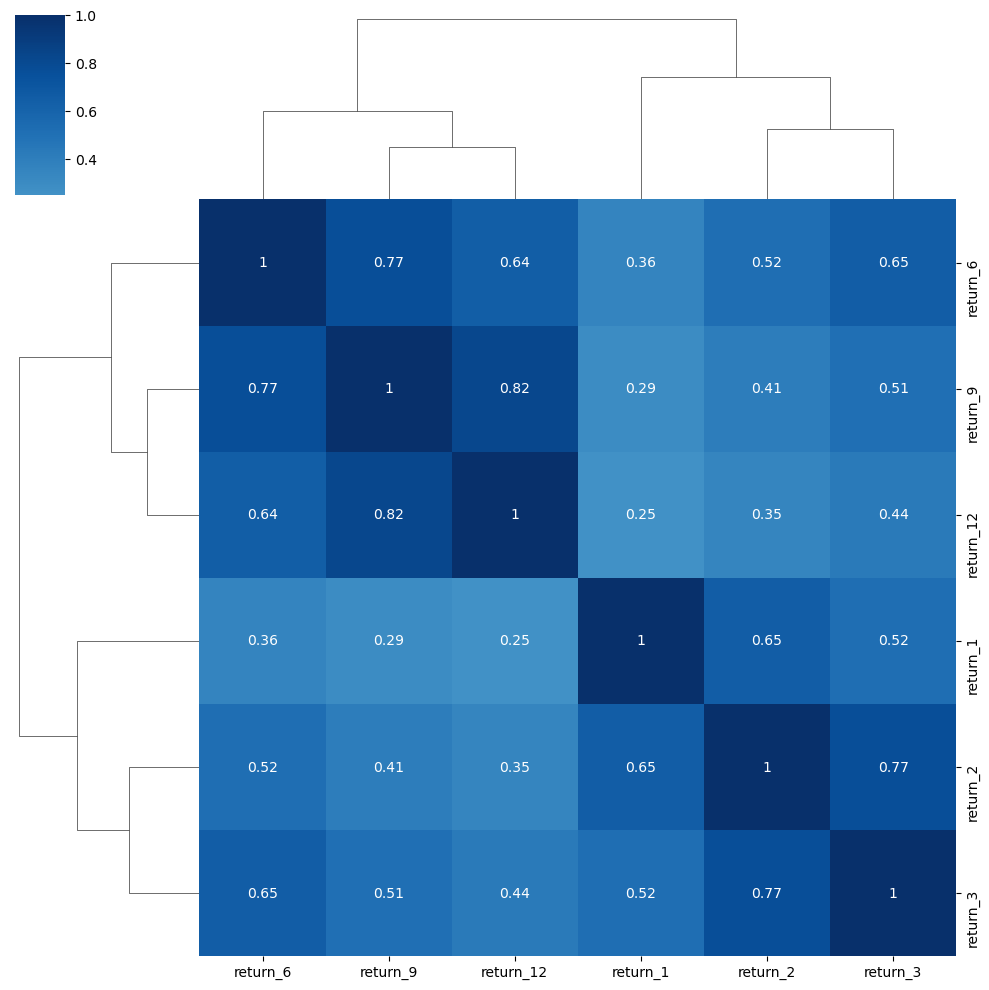

In [198]:

# get clustermap 

sns.clustermap(monthly_stats.corr('spearman'), annot=True, center=0, cmap='Blues');


### FEMA Factors

Fama and French found that value stocks outperform growth stocks. Similarly, small-cap stocks tend to outperform large-cap stocks. As an evaluation tool, the performance of portfolios with a large number of small-cap or value stocks would be lower than the CAPM result


$R_{it} — R_{Ft} = a_i + b_i(R_{Mt} — R_{Ft}) + s_i SMB_t + h_i HML_t + r_i RMW_t + c_i CMA_t + e_it$

The five factors used:

- $R_{ft}$ is the return in month t of one of the portfolios
- $R_{Ft}$ is the riskfree rate
- small minus big (SMB): accounts for publicly traded companies with small market caps that generate higher returns.
- high minus low (HML): accounts for value stocks with high book-to-market ratios that generate higher returns
- robust minus weak (RMW) is the return spread of the most profitable firms minus the least profitable
- conservative minus aggressive (CMA) is the return spread of firms that invest conservatively minus aggressively (AQR, 2014)


A discussion on their performance can be found [Fama and French: The Five-Factor Model Revisited](https://blogs.cfainstitute.org/investor/2022/01/10/fama-and-french-the-five-factor-model-revisited/)




In [199]:
# download the data 

fema = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
fema_data = pdr.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='1990')[0].drop('RF', axis=1)

# make index DatetimeIndex to sample Monthly
fema_data.index = fema_data.index.to_timestamp()
fema_data = fema_data.resample('M').last().div(100)
fema_data.index.name = 'date'

fema_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
1990-01-31,-0.0785,-0.0131,0.0085,-0.0117,0.0135
1990-02-28,0.0111,0.0117,0.0064,-0.0003,-0.0066
1990-03-31,0.0183,0.0162,-0.0292,0.0204,-0.0102
1990-04-30,-0.0336,-0.0033,-0.0259,0.0178,-0.0098
1990-05-31,0.0842,-0.0235,-0.0383,0.0157,-0.0168


In [200]:
# join the data with monthly_stats frame

fema_data = fema_data.join(monthly_stats['return_1'])

fema_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401322 entries, ('A', Timestamp('2000-11-30 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Mkt-RF    401322 non-null  float64
 1   SMB       401322 non-null  float64
 2   HML       401322 non-null  float64
 3   RMW       401322 non-null  float64
 4   CMA       401322 non-null  float64
 5   return_1  401322 non-null  float64
dtypes: float64(6)
memory usage: 20.0+ MB


### Rolling beta


In simple linear regression, the model is often represented as:

$ Y = \beta_0 + \beta_1 \cdot X + \varepsilon $

where:
- $ Y $ is the dependent variable,
- $ X $ is the independent variable,
- $ \beta_0 $ is the intercept,
- $ \beta_1 $ is the slope,
- $ \varepsilon $ is the error term.

endog: The dependent variable or the "Y" variable in the regression model. The `add_constant` function adds a column of ones to the independent variable, effectively incorporating the intercept term into the regression. So, the line `exog=sm.add_constant(df['X'])` ensures that the OLS model includes an intercept term in addition to the independent variable `X`. This is important for obtaining accurate and interpretable regression coefficients. the **window** is the size of the rolling window, i.e., the number of observations used for each OLS regression. It determines how many data points are considered at a time.


In [201]:
# use linear regression to get rolling beta

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# window length 2 yrs
T=24

beta = (fema_data.groupby(level='ticker', group_keys=False) # group by ticker
         .apply(lambda x: RollingOLS(endog=x.return_1,
                                     exog=sm.add_constant(x.drop('return_1', axis=1)),
                                     window=min(T, x.shape[0]-1))
        .fit(params_only=True)  # fit the model 
        .params # get only the params
        .drop('const', axis=1))) # drop constant column as we only need slope



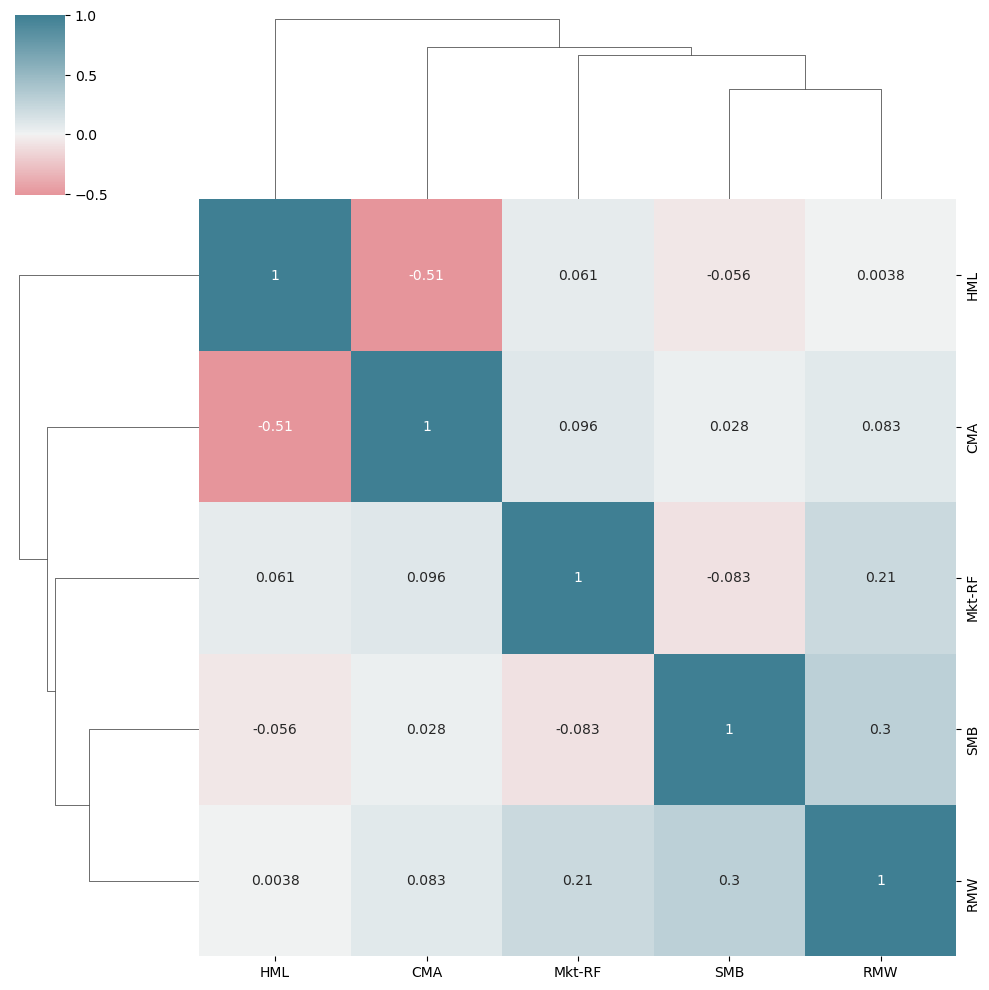

In [202]:
# get correlations of beta for parameters

cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(beta.corr(), annot=True, cmap=cmap, center=0);


### Join Beta with stock data



In [203]:
monthly_stats = monthly_stats.join(beta.groupby(level='ticker').shift())

In [204]:
monthly_stats

return_1  return_2  return_3  return_6  return_9  \
ticker date                                                           
A      2000-11-30  0.126970  0.032670 -0.050666 -0.055746 -0.073651   
       2000-12-31  0.049052  0.087313  0.038102 -0.048438 -0.068809   
       2001-01-31 -0.003653  0.022360  0.056104  0.049811 -0.052500   
       2001-02-28 -0.304551 -0.189115 -0.116435 -0.084141 -0.076425   
       2001-03-31 -0.146389 -0.233581 -0.175116 -0.074628 -0.092690   
...                     ...       ...       ...       ...       ...   
ZUMZ   2017-11-30  0.235127  0.097461  0.205302  0.073430  0.007402   
       2017-12-31 -0.044725  0.086226  0.047857  0.090987  0.014465   
       2018-01-31 -0.003601 -0.024380  0.055418  0.085265  0.016237   
       2018-02-28 -0.050602 -0.027386 -0.033200  0.079484  0.036640   
       2018-03-31  0.197970  0.066466  0.042579  0.045215  0.074606   

                   return_12    Mkt-RF       SMB       HML       RMW       CMA  
ticker date                                                                     
A      2000-11-30   0.017884       NaN       NaN       NaN       NaN       NaN  
       2000-12-31  -0.028344       NaN       NaN       NaN       NaN       NaN  
       2001-01-31  -0.015988       NaN       NaN       NaN       NaN       NaN  
       2001-02-28  -0.084537       NaN       NaN       NaN       NaN       NaN  
       2001-03-31  -0.096606       NaN       NaN       NaN       NaN       NaN  
...                      ...       ...       ...       ...       ...       ...  
ZUMZ   2017-11-30  -0.010687 -0.776433  0.959569  1.362841  3.000538  1.231247  
       2017-12-31  -0.003996 -0.759633  1.264886  1.337637  3.503348  0.970208  
       2018-01-31   0.002864 -0.953683  1.594600  1.530802  3.682565  0.325975  
       2018-02-28  -0.002905  0.067096  1.097990  1.324415  3.016462  0.635845  
       2018-03-31   0.021422  0.325970  0.963461  1.351028  2.747386  0.662042  

[401322 rows x 11 columns]

In [205]:
# fill nan with mean values

monthly_stats.loc[:,fema] = monthly_stats.groupby('ticker')[fema].apply(lambda x: x.fillna(x.mean())).reset_index(0)

monthly_stats

return_1  return_2  return_3  return_6  return_9  \
ticker date                                                           
A      2000-11-30  0.126970  0.032670 -0.050666 -0.055746 -0.073651   
       2000-12-31  0.049052  0.087313  0.038102 -0.048438 -0.068809   
       2001-01-31 -0.003653  0.022360  0.056104  0.049811 -0.052500   
       2001-02-28 -0.304551 -0.189115 -0.116435 -0.084141 -0.076425   
       2001-03-31 -0.146389 -0.233581 -0.175116 -0.074628 -0.092690   
...                     ...       ...       ...       ...       ...   
ZUMZ   2017-11-30  0.235127  0.097461  0.205302  0.073430  0.007402   
       2017-12-31 -0.044725  0.086226  0.047857  0.090987  0.014465   
       2018-01-31 -0.003601 -0.024380  0.055418  0.085265  0.016237   
       2018-02-28 -0.050602 -0.027386 -0.033200  0.079484  0.036640   
       2018-03-31  0.197970  0.066466  0.042579  0.045215  0.074606   

                   return_12    Mkt-RF       SMB       HML       RMW       CMA  
ticker date                                                                     
A      2000-11-30   0.017884  1.273188  0.577752 -0.674936 -1.230607  0.695724  
       2000-12-31  -0.028344  1.273188  0.577752 -0.674936 -1.230607  0.695724  
       2001-01-31  -0.015988  1.273188  0.577752 -0.674936 -1.230607  0.695724  
       2001-02-28  -0.084537  1.273188  0.577752 -0.674936 -1.230607  0.695724  
       2001-03-31  -0.096606  1.273188  0.577752 -0.674936 -1.230607  0.695724  
...                      ...       ...       ...       ...       ...       ...  
ZUMZ   2017-11-30  -0.010687 -0.776433  0.959569  1.362841  3.000538  1.231247  
       2017-12-31  -0.003996 -0.759633  1.264886  1.337637  3.503348  0.970208  
       2018-01-31   0.002864 -0.953683  1.594600  1.530802  3.682565  0.325975  
       2018-02-28  -0.002905  0.067096  1.097990  1.324415  3.016462  0.635845  
       2018-03-31   0.021422  0.325970  0.963461  1.351028  2.747386  0.662042  

[401322 rows x 11 columns]

## Momentum Factors

Taking the difference between the return for long term and most recent month as a proxy of momentum. 

In [206]:
for lag in [2,3,6,9,12]:
    monthly_stats[f'momentum_{lag}'] = monthly_stats[f'return_{lag}'].sub(monthly_stats.return_1)

# momentum 12month - 3 month return
monthly_stats[f'momentum_3_12'] = monthly_stats[f'return_12'].sub(monthly_stats.return_3)

In [207]:
monthly_stats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401322 entries, ('A', Timestamp('2000-11-30 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1       401322 non-null  float64
 1   return_2       401322 non-null  float64
 2   return_3       401322 non-null  float64
 3   return_6       401322 non-null  float64
 4   return_9       401322 non-null  float64
 5   return_12      401322 non-null  float64
 6   Mkt-RF         401322 non-null  float64
 7   SMB            401322 non-null  float64
 8   HML            401322 non-null  float64
 9   RMW            401322 non-null  float64
 10  CMA            401322 non-null  float64
 11  momentum_2     401322 non-null  float64
 12  momentum_3     401322 non-null  float64
 13  momentum_6     401322 non-null  float64
 14  momentum_9     401322 non-null  float64
 15  momentum_12    401322 non-null  float64
 16  

In [208]:
monthly_stats.head()

return_1  return_2  return_3  return_6  return_9  \
ticker date                                                           
A      2000-11-30  0.126970  0.032670 -0.050666 -0.055746 -0.073651   
       2000-12-31  0.049052  0.087313  0.038102 -0.048438 -0.068809   
       2001-01-31 -0.003653  0.022360  0.056104  0.049811 -0.052500   
       2001-02-28 -0.304551 -0.189115 -0.116435 -0.084141 -0.076425   
       2001-03-31 -0.146389 -0.233581 -0.175116 -0.074628 -0.092690   

                   return_12    Mkt-RF       SMB       HML       RMW  \
ticker date                                                            
A      2000-11-30   0.017884  1.273188  0.577752 -0.674936 -1.230607   
       2000-12-31  -0.028344  1.273188  0.577752 -0.674936 -1.230607   
       2001-01-31  -0.015988  1.273188  0.577752 -0.674936 -1.230607   
       2001-02-28  -0.084537  1.273188  0.577752 -0.674936 -1.230607   
       2001-03-31  -0.096606  1.273188  0.577752 -0.674936 -1.230607   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2000-11-30  0.695724   -0.094300   -0.177636   -0.182717   -0.200621   
       2000-12-31  0.695724    0.038262   -0.010949   -0.097490   -0.117860   
       2001-01-31  0.695724    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.695724    0.115436    0.188116    0.220411    0.228126   
       2001-03-31  0.695724   -0.087193   -0.028727    0.071761    0.053699   

                   momentum_12  momentum_3_12  
ticker date                                    
A      2000-11-30    -0.109087       0.068549  
       2000-12-31    -0.077396      -0.066446  
       2001-01-31    -0.012335      -0.072092  
       2001-02-28     0.220014       0.031898  
       2001-03-31     0.049783       0.078511

In [209]:
# date indicators

dates = monthly_stats.index.get_level_values('date')
monthly_stats['year'] = dates.year
monthly_stats['month'] = dates.month


## Lagged Returns

Shift the returns by 1-7 Months to get lagged returns

In [210]:
for t in range(1, 7):
    monthly_stats[f'return_1m_t-{t}'] = monthly_stats.groupby(level='ticker').return_1.shift(t)


## Taget Variable

Create the target variable which will be forward looking returns for various months.

In [211]:
for t in [1,2,3,6,12]:
    monthly_stats[f'target_{t}'] = monthly_stats.groupby(level='ticker')[f'return_{t}'].shift(-t)

In [212]:
monthly_stats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401322 entries, ('A', Timestamp('2000-11-30 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1       401322 non-null  float64
 1   return_2       401322 non-null  float64
 2   return_3       401322 non-null  float64
 3   return_6       401322 non-null  float64
 4   return_9       401322 non-null  float64
 5   return_12      401322 non-null  float64
 6   Mkt-RF         401322 non-null  float64
 7   SMB            401322 non-null  float64
 8   HML            401322 non-null  float64
 9   RMW            401322 non-null  float64
 10  CMA            401322 non-null  float64
 11  momentum_2     401322 non-null  float64
 12  momentum_3     401322 non-null  float64
 13  momentum_6     401322 non-null  float64
 14  momentum_9     401322 non-null  float64
 15  momentum_12    401322 non-null  float64
 16  

### Age of Company

We can use the IPO year as the age of the company

In [213]:
monthly_stats = (monthly_stats.join(pd.qcut(stocks_meta.ipoyear, q=5, labels=list(range(1, 6))) # bin the ipoyear in 5 quartiles
              .astype(float) # convert to float because of NaNs can't be converted to int directly
              .fillna(0) # fill nan with 0
              .astype(int) # convert to int
              .to_frame('age') # conver to dataframe from Series
              ))

# fill nan with -1
monthly_stats.age = monthly_stats.age.fillna(-1)

### Dynamic size

We can use the market cap as the dynamic size of the company.

In [214]:
# get cummulative returns for each ticker
size_factor = (stocks_prices_monthly
               .loc[monthly_stats.index.get_level_values('date').unique(),
                    monthly_stats.index.get_level_values('ticker').unique()]
                    #select date and ticker
               .sort_index(ascending=False)
               .pct_change() # get percentage change to ger return
               .fillna(0) # fill nan with 0
               .add(1)   # add one to get geometric mean
               .cumprod()) # get cummulative returns for each ticker

# get marketcap for each ticker
market_cap = (size_factor.mul(stocks_meta
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')


In [215]:
# divide marketcap into deciles.

monthly_stats['marketcap_decile'] = (market_cap
                                     .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                                     .astype(int), axis=1) # convert to int each decile
                                     .stack() # get index as date, ticker
                                     .swaplevel() # get index as ticker, date
                                     )
# fill nan with -1
monthly_stats['marketcap_decile'] = monthly_stats['marketcap_decile'].fillna(-1)

# get the sectors for each ticker
monthly_stats = monthly_stats.join(stocks_meta.sector.to_frame('sector'))

# fill nan with Unknown 
monthly_stats.sector = monthly_stats.sector.fillna('Unknown')

In [216]:
monthly_stats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401322 entries, ('A', Timestamp('2000-11-30 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   return_1          401322 non-null  float64
 1   return_2          401322 non-null  float64
 2   return_3          401322 non-null  float64
 3   return_6          401322 non-null  float64
 4   return_9          401322 non-null  float64
 5   return_12         401322 non-null  float64
 6   Mkt-RF            401322 non-null  float64
 7   SMB               401322 non-null  float64
 8   HML               401322 non-null  float64
 9   RMW               401322 non-null  float64
 10  CMA               401322 non-null  float64
 11  momentum_2        401322 non-null  float64
 12  momentum_3        401322 non-null  float64
 13  momentum_6        401322 non-null  float64
 14  momentum_9        401322 non-null  float64

## Save the data


In [247]:
with pd.HDFStore(data_path) as store:
    store.put('engineered_features', monthly_stats.sort_index())
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../Findata/data.h5
/engineered_features            frame        (shape->[401322,33])  
/fred/SP500                     frame        (shape->[2608,1])     
/quandl/wiki/prices             frame        (shape->[15389314,12])
/quandl/wiki/stocks             frame        (shape->[1,2])        
/sp500/fred                     frame        (shape->[2608,1])     
/sp500/stocks                   frame        (shape->[503,8])      
/us_equities/stocks             frame        (shape->[7310,6])     
